<a href="https://colab.research.google.com/github/Trickshotblaster/nn-practices/blob/main/GoodShakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests

url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
text = requests.get(url)

In [2]:
import random

In [3]:
text = text.text

In [4]:
text = text.lower()
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

for ele in text:
    if ele in punc:
        text = text.replace(ele, "")

In [5]:
vocab = text.split()

In [6]:
vocab_dict = set()
for word in vocab:
  if random.randint(1, 10) > 7:
    vocab_dict.update([word])

In [7]:
len(vocab_dict)

6938

In [8]:
vocab_dict = sorted(vocab_dict)

In [9]:
stoi = {"[PAD]": 0, "[UNK]": 1}
itos = {0: "[PAD]", 1: "[UNK]"}
stoi.update({char:i+2 for i, char in enumerate(vocab_dict)})
itos.update({i+2:char for i, char in enumerate(vocab_dict)})

In [10]:
stoi['a']

3

In [11]:
itos[stoi['a']]

'a'

In [12]:
class Tokenizer:
  def __init__(self, stoi, itos, len=10):
    self.stoi = stoi
    self.itos = itos
    self.len = len
  def encode(self, text, crop=True, pad=True):
    out = []
    if crop:
      for word in text.lower().split()[:self.len]:
        if word in self.stoi:
          out.append(self.stoi[word])
        else:
          out.append(1)
      if pad:
        out = [0] * (self.len - len(out)) + out
      return out
    else:
      for word in text.lower().split():
        if word in self.stoi:
          out.append(self.stoi[word])
        else:
          out.append(1)
      if pad:
        out = [0] * (self.len - len(out)) + out
      return out
  def decode(self, ids):
    out = ""
    for id in ids:
      if (id in self.itos) and id != 1:
        out += self.itos[id] + " "
      elif id==0:
        out += '[PAD]'
      else:
        out += '[UNK] '
    return out

In [13]:
tokenizer = Tokenizer(stoi, itos)

In [14]:
tokenizer.encode("hello world", pad=False)

[1, 6841]

In [15]:
tokenizer.decode(tokenizer.encode("hello world", pad=False))

'[UNK] world '

In [16]:
import torch

In [17]:
import torch.nn.functional as F

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [55]:
num_epochs = 100000
lr = 10
batch_size = 64

In [88]:
context_len = 3
emb_dim = 20
vocab_size = len(stoi)
n_hidden = 200
C = torch.randn(vocab_size, emb_dim).to(device)
w1 = torch.randn(context_len * emb_dim, n_hidden).to(device) * 0.03
b1 = torch.randn(n_hidden).to(device) * 0.01
w2 = torch.randn(n_hidden, vocab_size).to(device) * 0.03
b2 = torch.randn(vocab_size).to(device) * 0.01

params = [C, w1, b1, w2, b2]
for p in params:
  p.requires_grad = True

tokenizer = Tokenizer(stoi, itos, len=context_len)

In [89]:
def build_dataset(text):
  xs = []
  ys = []
  tokenized_text = tokenizer.encode(text, crop=False)
  context = [0] * (context_len)
  for x in tokenized_text:
    xs.append(context)
    ys.append(x)
    context = context[1:] + [x]
  xs = torch.tensor(xs).to(device)
  ys = torch.tensor(ys).to(device)
  return xs, ys
Xtr, Ytr = build_dataset(text)
train_examples = len(Xtr) - 1

In [90]:
epochs = torch.arange(num_epochs)
losses = []

In [91]:
for epoch in range(num_epochs):
  batch_indices = torch.randint(0, train_examples, (batch_size, ))
  xs = Xtr[batch_indices]
  ys = Ytr[batch_indices]
  emb = C[xs].view(-1, emb_dim * context_len)
  l1 = (emb @ w1 + b1).tanh()
  logits = (l1 @ w2 + b2).tanh()
  loss = F.cross_entropy(logits, ys)

  losses.append(loss.item())

  for p in params:
    p.grad = None

  loss.backward()

  for p in params:
    p.data -= p.grad * (lr * ((epoch+1) ** -0.5))

  if epoch % 10000 == 0:
    print("Epoch", str(epoch) + ", loss:", loss.item())


Epoch 0, loss: 8.844220161437988
Epoch 10000, loss: 7.639857769012451
Epoch 20000, loss: 7.512453556060791
Epoch 30000, loss: 7.665687561035156
Epoch 40000, loss: 7.558454990386963
Epoch 50000, loss: 7.424802780151367
Epoch 60000, loss: 7.457253456115723
Epoch 70000, loss: 7.506791591644287
Epoch 80000, loss: 7.517706394195557
Epoch 90000, loss: 7.565774917602539


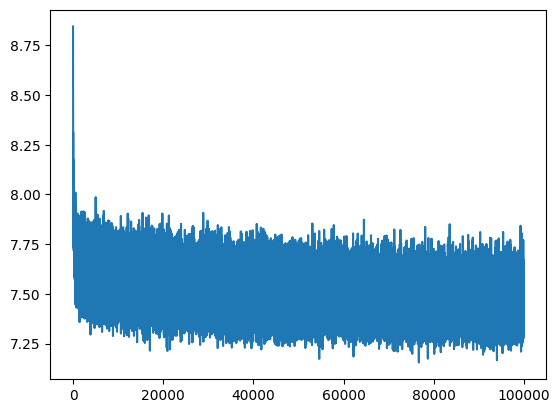

In [92]:
import matplotlib.pyplot as plt

plt.plot(epochs.numpy(), losses)

In [93]:
Xtr[100]

tensor([3001, 6031, 6863], device='cuda:0')

In [94]:
Ytr[100]

tensor(6909, device='cuda:0')

In [95]:
tokenizer.decode([Ytr[100].cpu().numpy().item()])

'yield '

In [96]:
tokenizer.decode(Xtr[100].cpu().numpy())

'if they would '

In [99]:
def prompt(text, len=10):
  output = text + " "
  for x in range(len):
    xs = torch.tensor(tokenizer.encode(output)).to(device)
    emb = C[xs].view(-1, emb_dim * context_len)
    l1 = (emb @ w1 + b1).tanh()
    logits = (l1 @ w2 + b2).tanh()
    outs = logits.softmax(dim=1)
    selected = torch.multinomial(outs, num_samples=1)[0].cpu().numpy()
    outchar = tokenizer.decode(selected)
    output += outchar
  return output

In [100]:
prompt("romeo")

'romeo stroke male ravisher follow on velvet realm freely done first '

In [101]:
prompt(tokenizer.decode(Xtr[100].cpu().numpy()))

'if they would  imagine nothing encourage feather late anon equals dreamd tell hath '